In [25]:
import h5py
import seaborn as sns
from moseq2_detectron_extract.io.annot import default_keypoint_names, default_keypoint_connection_rules
import matplotlib.pyplot as plt
import itertools
import math
import numpy as np
from moseq2_detectron_extract.stats import is_outlier
import statsmodels.api as sm
import pandas as pd
from sklearn import decomposition
from bottleneck import move_median, move_mean


In [3]:
h5 = h5py.File(r"E:\moseq_raw_data\detectron2_testing_full\session_20200915132521_top-score-vote\results_00.h5", 'r')

In [4]:
gt_first_3K_bad_keypoints = [31,40,45,97,102,112,113,114,115,118,119,126,132,218,230,234,235,238,245,246,247,375,376,377,378,379,380,382,383,385,395,614,683,739,753,1279,1301,1308,1314,1319,1320,1332,1335,1336,1337,1343,1348,1349,1352,1363,1364,1365,1366,1367,1368,1369,1370,1371,1373,1374,1375,1378,1379,1382,1383,1384,1385,1386,1387,1388,1390,1393,1394,1398,1399,1400,1401,1402,1403,1404,1405,1409,1411,1412,1413,1430,1431,1432,1434,1461,1462,1463,1464,1465,1466,1480,1484,1485,1486,1491,1494,1495,1500,1504,1505,1513,1515,1521,1523,1524,1525,1526,1527,1529,1533,1535,1540,1564,1566,1567,1568,1569,1573,1576,1578,1579,1580,1581,1582,1587,1588,1593,1594,1595,1596,1597,1599,1614,1616,1617,1618,1622,1624,1625,1626,1627,1629,1630,1631,1632,1636,1637,1638,1639,1641,1642,1661,1663,1664,1666,1667,1668,1669,1672,1673,1675,1676,1677,1681,1682,1685,1686,1687,1690,1691,1692,1693,1694,1695,1696,1697,1698,1700,1705,1707,1708,1710,1711,1712,1715,1716,1719,1723,1726,1730,1731,1732,1733,1734,1735,1736,1737,1738,1739,1741,1742,1743,1744,1745,1746,2127,2130,2131,2132,2133,2134,2135,2136,2138,2141,2143,2148,2150,2276,2695,2696,2697,2698,2699,2700,2701,2702,2703,2704,2705,2706,2707,2708,2709,2710,2711,2712,2719,2884,2886,2893,2907,2911,2913,2914,2915,2916,2917,2921,2922,2925,2926,2927,2928,2929,2930,2931,2932,2933]

In [5]:
def calc_keypoint_dist(h5, keypoints=default_keypoint_names, units='mm'):
    keys = ['/keypoints/reference/{}'.format(kp) for kp in keypoints if kp != 'TailTip'] + ['/scalars/centroid']
    ndists = int(math.factorial(len(keys)) / math.factorial(2) / math.factorial(len(keys) - 2))
    dist = np.ndarray((h5['frames'].shape[0], ndists), dtype=float)
    labels = []
    for i, (kp1, kp2) in enumerate(itertools.combinations(keys, 2)):
        labels.append(f'{kp1} vs {kp2}')
        x1 = h5[f'{kp1}_x_{units}'][()]
        y1 = h5[f'{kp1}_y_{units}'][()]
        x2 = h5[f'{kp2}_x_{units}'][()]
        y2 = h5[f'{kp2}_y_{units}'][()]
        dist[:, i] = np.sqrt( ((x1-x2)**2) + ((y1-y2)**2) )
    return dist, labels

In [6]:
dists, labels = calc_keypoint_dist(h5)
print(dists.shape)
for i, l in enumerate(labels):
    print(f'{i}) {l}')

(6000, 28)
0) /keypoints/reference/Nose vs /keypoints/reference/Left Ear
1) /keypoints/reference/Nose vs /keypoints/reference/Right Ear
2) /keypoints/reference/Nose vs /keypoints/reference/Neck
3) /keypoints/reference/Nose vs /keypoints/reference/Left Hip
4) /keypoints/reference/Nose vs /keypoints/reference/Right Hip
5) /keypoints/reference/Nose vs /keypoints/reference/TailBase
6) /keypoints/reference/Nose vs /scalars/centroid
7) /keypoints/reference/Left Ear vs /keypoints/reference/Right Ear
8) /keypoints/reference/Left Ear vs /keypoints/reference/Neck
9) /keypoints/reference/Left Ear vs /keypoints/reference/Left Hip
10) /keypoints/reference/Left Ear vs /keypoints/reference/Right Hip
11) /keypoints/reference/Left Ear vs /keypoints/reference/TailBase
12) /keypoints/reference/Left Ear vs /scalars/centroid
13) /keypoints/reference/Right Ear vs /keypoints/reference/Neck
14) /keypoints/reference/Right Ear vs /keypoints/reference/Left Hip
15) /keypoints/reference/Right Ear vs /keypoints/ref

(array([1398, 1400, 1404, 2133, 2139, 2140, 2142, 2143, 2144, 2243, 2249,
        2254, 2258, 2259, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268,
        2270, 2271, 2272, 2414, 2428, 2550, 2583, 2929, 3469, 3579, 3580,
        3581, 3582, 3586, 3599, 3600, 3601, 3619, 3620, 3625, 3626, 4849,
        4850, 4853, 4854, 4855, 4857, 4860, 4867, 4917, 4936, 4941, 4942,
        4945, 4946, 4948, 4949, 4951, 5203, 5205, 5206, 5207, 5447, 5448,
        5450, 5938], dtype=int64),)

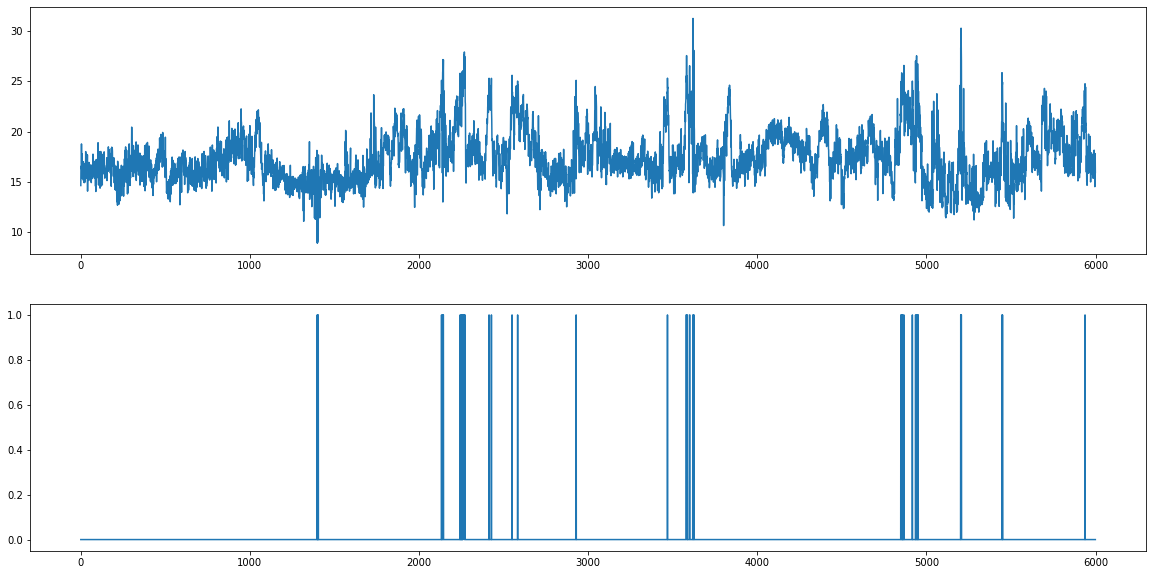

In [5]:
dist_idx = 26
outliers = is_outlier(dists[:,dist_idx])
fig, axs = plt.subplots(2, 1, figsize=(20,10))
axs[0].plot(dists[:,dist_idx])
axs[1].plot(outliers)
np.where(outliers)

In [26]:
outliers = np.zeros_like(dists, dtype='bool')
for i in range(outliers.shape[1]):
    outliers[:, i] = is_outlier(dists[:, i])
outlier_any = np.any(outliers, axis=1)
outlier_idxs = np.where(outlier_any)[0]
print(outlier_idxs.shape)
outlier_idxs

(621,)


array([  31,   40,   45,   94,   97,  102,  109,  112,  113,  114,  115,
        118,  119,  126,  132,  192,  218,  230,  234,  235,  238,  245,
        246,  247,  373,  375,  376,  377,  378,  379,  380,  382,  383,
        385,  395,  610,  614,  683,  739,  753,  762, 1144, 1153, 1173,
       1176, 1181, 1279, 1285, 1301, 1308, 1314, 1319, 1320, 1321, 1325,
       1332, 1335, 1336, 1337, 1343, 1346, 1348, 1349, 1352, 1353, 1363,
       1365, 1366, 1367, 1368, 1369, 1370, 1373, 1374, 1375, 1376, 1378,
       1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1390,
       1391, 1393, 1394, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405,
       1409, 1411, 1412, 1413, 1430, 1431, 1432, 1434, 1437, 1438, 1439,
       1440, 1441, 1442, 1443, 1459, 1461, 1462, 1463, 1464, 1465, 1466,
       1480, 1484, 1485, 1486, 1491, 1492, 1494, 1495, 1500, 1504, 1505,
       1512, 1513, 1515, 1518, 1520, 1521, 1523, 1524, 1525, 1526, 1527,
       1528, 1529, 1530, 1533, 1534, 1535, 1537, 15

In [34]:
pca = decomposition.FastICA(n_components=7)
pca_result = pca.fit_transform(dists)
pca_result

array([[-0.01522847,  0.01158073,  0.00168931, ...,  0.00025978,
        -0.00128601,  0.0213215 ],
       [-0.02311007,  0.00775326, -0.00419278, ..., -0.00304171,
         0.00330542,  0.01887418],
       [-0.01771095,  0.00756591, -0.00181522, ..., -0.00367871,
         0.00525538,  0.0179514 ],
       ...,
       [ 0.00079693, -0.01058253,  0.00554882, ...,  0.00281368,
         0.00411243,  0.0107225 ],
       [ 0.00482488, -0.01622674,  0.00450089, ..., -0.00524657,
         0.0053831 ,  0.0037214 ],
       [ 0.00478713, -0.01401508,  0.00441187, ..., -0.00120831,
         0.00066317,  0.00302163]])

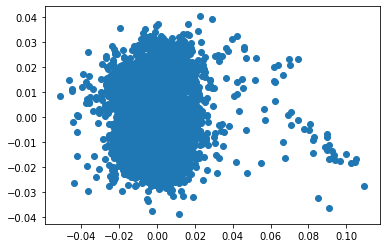

In [35]:
plt.scatter(pca_result[:,0], pca_result[:,1])

In [7]:
def load_keypoint_data(h5, keypoints, units='px'):
    keys = ['/keypoints/reference/{}'.format(kp) for kp in keypoints]
    data = np.ndarray((h5['frames'].shape[0], len(keys), 3), dtype=float)
    for kpi, kp in enumerate(keys):
        data[:, kpi, 0] = h5[f'{kp}_x_{units}'][()]
        data[:, kpi, 1] = h5[f'{kp}_y_{units}'][()]
        data[:, kpi, 2] = h5[f'{kp}_score'][()]
    return data

def compare_sets(gt, query):
    gt = set(gt)
    query = set(query)
    print(f'GT contains {len(gt)} items')
    print(f'Query contains {len(query)} items')
    
    intersection = gt & query
    print(f'Intersection contains {len(intersection)} items ({len(intersection)/len(gt):.2%} of GT)')
    



def convertparms2start(pn):
    """ Creating a start value for sarimax in case of an value error
    See: https://groups.google.com/forum/#!topic/pystatsmodels/S_Fo53F25Rk """
    if "ar." in pn:
        return 0
    elif "ma." in pn:
        return 0
    elif "sigma" in pn:
        return 1
    else:
        return 0


def FitSARIMAXModel(x, p, pcutoff, alpha, ARdegree, MAdegree, nforecast=0, disp=False):
    # Seasonal Autoregressive Integrated Moving-Average with eXogenous regressors (SARIMAX)
    # see http://www.statsmodels.org/stable/statespace.html#seasonal-autoregressive-integrated-moving-average-with-exogenous-regressors-sarimax
    Y = x.copy()
    Y[p < pcutoff] = np.nan  # Set uncertain estimates to nan (modeled as missing data)
    if np.sum(np.isfinite(Y)) > 10:

        # SARIMAX implemetnation has better prediction models than simple ARIMAX (however we do not use the seasonal etc. parameters!)
        mod = sm.tsa.statespace.SARIMAX(
            Y.flatten(),
            order=(ARdegree, 0, MAdegree),
            seasonal_order=(0, 0, 0, 0),
            simple_differencing=True,
        )
        # Autoregressive Moving Average ARMA(p,q) Model
        # mod = sm.tsa.ARIMA(Y, order=(ARdegree,0,MAdegree)) #order=(ARdegree,0,MAdegree)
        try:
            res = mod.fit(disp=disp)
        except ValueError:  # https://groups.google.com/forum/#!topic/pystatsmodels/S_Fo53F25Rk (let's update to statsmodels 0.10.0 soon...)
            startvalues = np.array([convertparms2start(pn) for pn in mod.param_names])
            res = mod.fit(start_params=startvalues, disp=disp)
        except np.linalg.LinAlgError:
            # The process is not stationary, but the default SARIMAX model tries to solve for such a distribution...
            # Relaxing those constraints should do the job.
            mod = sm.tsa.statespace.SARIMAX(
                Y.flatten(),
                order=(ARdegree, 0, MAdegree),
                seasonal_order=(0, 0, 0, 0),
                simple_differencing=True,
                enforce_stationarity=False,
                enforce_invertibility=False,
                use_exact_diffuse=False,
            )
            res = mod.fit(disp=disp)

        predict = res.get_prediction(end=mod.nobs + nforecast - 1)
        return predict.predicted_mean, predict.conf_int(alpha=alpha)
    else:
        return np.nan * np.zeros(len(Y)), np.nan * np.zeros((len(Y), 2))


def compute_deviations(
    h5, keypoints, p_bound, alpha, ARdegree, MAdegree, storeoutput=None
):
    """ Fits Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model to data and computes confidence interval
    as well as mean fit. """

    print("Fitting state-space models with parameters:", ARdegree, MAdegree)
    data = load_keypoint_data(h5, keypoints)
    preds = []
    for row in range(data.shape[1]):
        x = data[:, row, 0]
        y = data[:, row, 1]
        p = data[:, row, 2]
        meanx, CIx = FitSARIMAXModel(x, p, p_bound, alpha, ARdegree, MAdegree)
        meany, CIy = FitSARIMAXModel(y, p, p_bound, alpha, ARdegree, MAdegree)
        distance = np.sqrt((x - meanx) ** 2 + (y - meany) ** 2)
        significant = (
            (x < CIx[:, 0]) + (x > CIx[:, 1]) + (y < CIy[:, 0]) + (y > CIy[:, 1])
        )
        preds.append(np.c_[distance, significant, meanx, meany, CIx, CIy])

    prod = [[kp for kp in keypoints]]
    prod.append(
        [
            "distance",
            "sig",
            "meanx",
            "meany",
            "lowerCIx",
            "higherCIx",
            "lowerCIy",
            "higherCIy",
        ]
    )
    pdindex = pd.MultiIndex.from_product(prod, names=['keypoint', 'model'])
    data = pd.DataFrame(np.concatenate(preds, axis=1), columns=pdindex)
    # average distance and average # significant differences avg. over comparisonbodyparts
    d = data.xs("distance", axis=1, level=-1).mean(axis=1).values
    o = data.xs("sig", axis=1, level=-1).mean(axis=1).values

    if storeoutput == "full":
        data.to_hdf(
            dataname.split(".h5")[0] + "filtered.h5",
            "df_with_missing",
            format="table",
            mode="w",
        )
        return d, o, data
    else:
        return d, o

In [58]:
d, o = compute_deviations(h5, default_keypoint_names, p_bound=0.01, alpha=0.01, ARdegree=3, MAdegree=1)

Fitting state-space models with parameters: 3 1


C:\Users\Josh\anaconda3\envs\moseq-detectron\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Josh\anaconda3\envs\moseq-detectron\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Josh\anaconda3\envs\moseq-detectron\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Josh\anaconda3\envs\moseq-detectron\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  wa

In [59]:
np.count_nonzero(o)

1086

In [35]:
def find_outliers_jumping(h5, keypoints, epsilon=30):
    data = load_keypoint_data(h5, keypoints)
    data = data[:,:,:2] # drop scores
    #print(np.expand_dims(data[0, :, :], axis=0).shape)
    diff = np.diff(data, axis=0, ) ** 2 # n=1, prepend=np.expand_dims(data[0, :, :], axis=0)
    #print(diff)
    dist = np.sum(diff, axis=2)
    #print(dist, dist.shape)
    ind = np.where((dist > epsilon ** 2).any(axis=1))[0]
    
    return ind, dist

def find_outliers_jumping2(h5, keypoints, window=6, thresh=3.5):
    data = load_keypoint_data(h5, keypoints)
    data = data[:,:,:2] # drop scores
    #print(data.shape)
    windows = move_median(data, window=window, min_count=1, axis=0)
    #print(windows.shape)
    diff = (data - windows) ** 2
    dist = np.sqrt(np.sum(diff, axis=2))
    print(dist.shape)
    
    outliers = np.zeros(dist.shape[:2], dtype=bool)
    for i in range(dist.shape[1]):
        outliers[:,i] = is_outlier(dist[:,i], thresh=thresh)
    ind = np.where(outliers.any(axis=1))[0]
    print(outliers.shape)
    print(ind.shape)
    
    
    return ind, dist, outliers
    

def plot_temporal_distances(dist, keypoints):
    fig, axs = plt.subplots(dist.shape[1], 1, figsize=(60, 30))
    for i in range(len(keypoints)):
        axs[i].plot(dist[:, i])
        axs[i].set_title(keypoints[i])
        axs[i].xaxis.set_ticks(np.arange(dist.shape[0]))
        for label in axs[i].get_xticklabels():
            label.set_rotation(90)
    fig.tight_layout()
    return fig

In [36]:
kpts = [kp for kp in default_keypoint_names if kp != 'TailTip']
ind, dist, outliers = find_outliers_jumping2(h5, kpts, window=6, thresh=7)
#fig = plot_temporal_distances(dist, kpts)
compare_sets(gt_first_3K_bad_keypoints, ind)

(6000, 7)
(6000, 7)
(828,)
GT contains 264 items
Query contains 828 items
Intersection contains 222 items (84.09% of GT)


c:\users\josh\git\moseq2\moseq2-detectron-extract\moseq2_detectron_extract\stats.py:28: RuntimeWarning: invalid value encountered in true_divide
  modified_z_score = 0.6745 * diff / med_abs_deviation


Settings with best F1 score:
Window=4.0; thresh=10.0


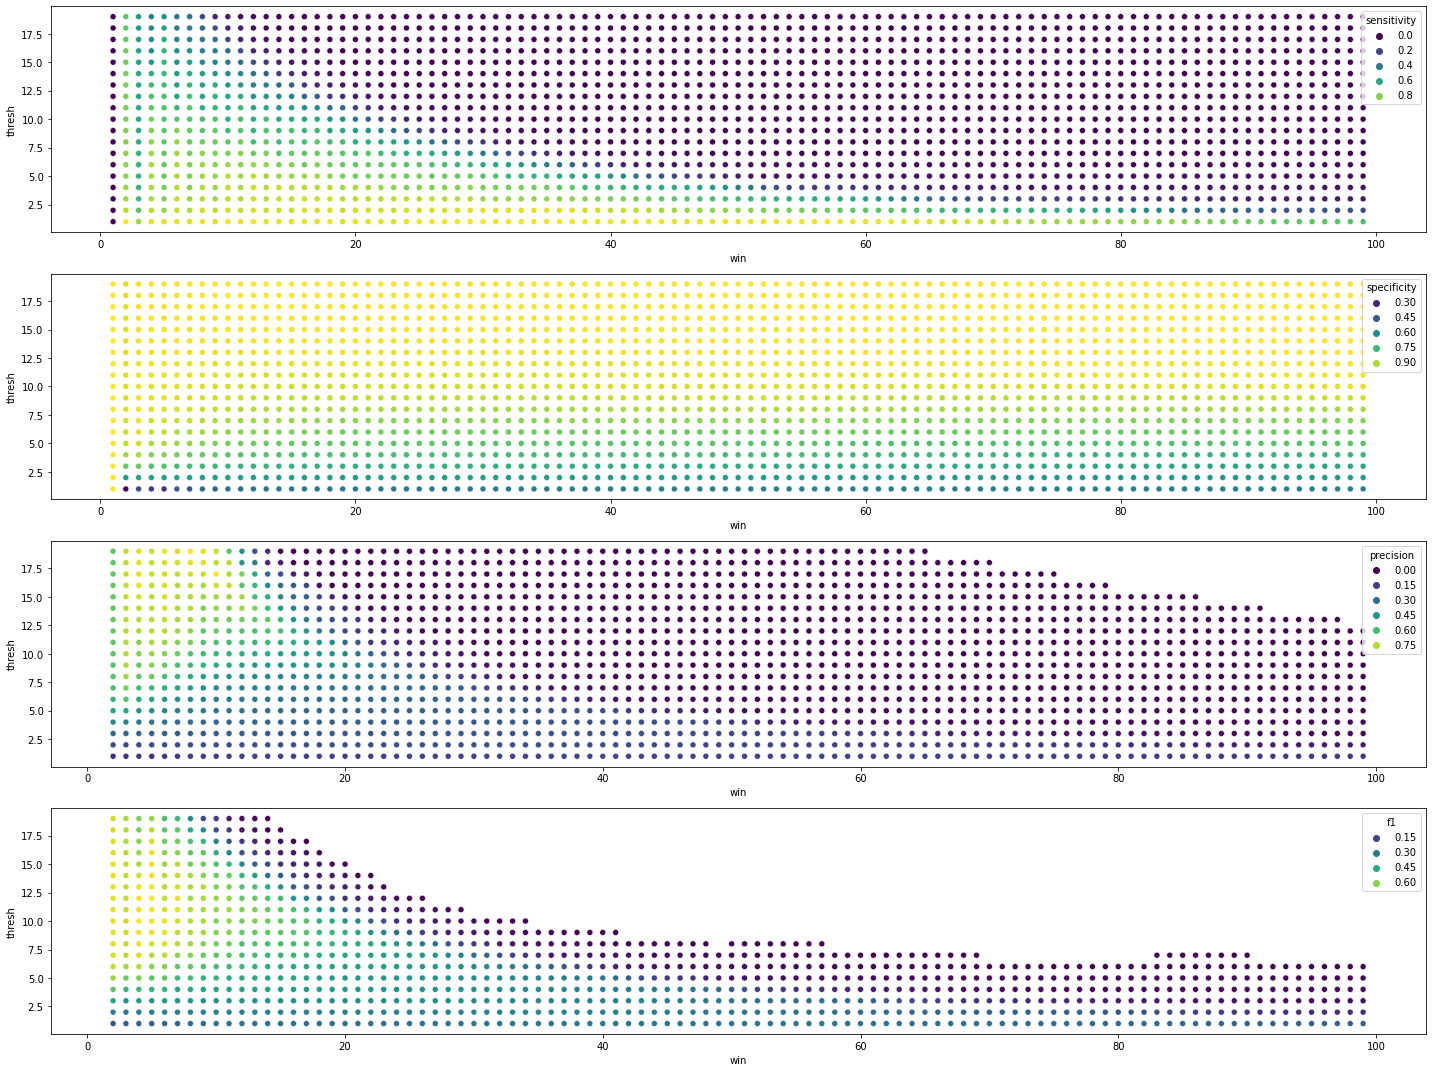

In [34]:
windows_to_try = np.arange(1, 100)
thresholds_to_try = np.arange(1, 20)

results = []
for win in windows_to_try:
    for thresh in thresholds_to_try:
        ind, dist, outliers = find_outliers_jumping2(h5, kpts, window=win, thresh=thresh)
        ind = ind[ind<3000]
        
        true_pos = len(set(gt_first_3K_bad_keypoints) & set(ind))
        true_neg = len(set(np.arange(3000)) - set(gt_first_3K_bad_keypoints) - set(ind))
        false_pos = len(set(ind) - set(gt_first_3K_bad_keypoints))
        false_neg = len(set(gt_first_3K_bad_keypoints) - set(ind))
        
        #print(f'{true_pos}/{true_neg}/{false_pos}/{false_neg} = {sum([true_pos, true_neg, false_pos, false_neg])}')
        
        sensitivity = true_pos / (true_pos + false_neg) # same as recall
        specificity = true_neg / (true_neg + false_pos)
        try:
            precision = true_pos / (true_pos + false_pos)
        except:
            precision = math.nan
            
        try:
            f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))
        except:
            f1 = math.nan
        
        results.append({
            'win': win,
            'thresh': thresh,
            'true_pos': true_pos,
            'true_neg': true_neg,
            'false_pos': false_pos,
            'false_neg': false_neg,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'precision': precision,
            'f1': f1
        })
results = pd.DataFrame(results)

print("Settings with best F1 score:")
best_model = results.iloc[results['f1'].idxmax()]
print(f"Window={best_model['win']}; thresh={best_model['thresh']}")

fig, axs = plt.subplots(4, 1, figsize=(20, 15))
sns.scatterplot(data=results, x="win", y="thresh", hue='sensitivity', palette='viridis', ax=axs[0])
sns.scatterplot(data=results, x="win", y="thresh", hue='specificity', palette='viridis', ax=axs[1])
sns.scatterplot(data=results, x="win", y="thresh", hue='precision', palette='viridis', ax=axs[2])
sns.scatterplot(data=results, x="win", y="thresh", hue='f1', palette='viridis', ax=axs[3])
fig.tight_layout()



In [75]:
ind = np.where(is_outlier(dist, thresh=7))[0]
compare_sets(gt_first_3K_bad_keypoints, ind)

GT contains 264 items
Query contains 952 items
Intersection contains 211 items (79.92% of GT)


In [32]:
results.to_csv('outlier_pred.tsv', sep='\t', index=False)

In [85]:
outliers.any()

False

In [13]:
dist.shape

(6000, 7)